# TEDOPA

This notebook explains the use of the functions in **tedopa.py**. The purpose of these functions is to map the Hamiltonian of an open quantum system, linearly coupled to an environment of continuous bosonic modes, to a one dimensional chain and then perform time evolution on it. In addition to reading this notebook, make sure to also have a look at the [introduction](https://github.com/MoritzLange/py-tedopa/blob/master/examples/introduction.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mpnum as mp
from tedopa import tmps
from tedopa import tedopa as td


## The full TEDOPA algorithm
The functions `tedopa1`, for one site coupled to an environment, or `tedopa2`, for two coupled sites each coupled to an individual environment, are quite easy to use. The only work required by the user is to define the parameters for the simulation.

## `tedopa1`
First, an initial state of system plus environment (as MPA) needs to be created. In this case it will be a system of one two-level-site, prepared as (1 &frasl; &radic;2) (&#8739;e&rang; + &#8739;g&rang;). The mapping within TEDOPA will map the Hamiltonian of the continuous environment to a discrete chain. With the initial state, the user can decide how long that chain should be, what the dimension (i.e. size of the state vector/density matrix) of each oscillator in the chain will be and what the ground state of the environment is. In our case, the chain will be 120 sites long, each oscillator has a dimension of 8 and the whole environment, i.e. each oscillator, is in ground state. The initial state is chosen to be an MPS. An MPO or PMPS could be used as well.

In [2]:
system_site = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
chain_element = np.array([1] + [0] * 7)  # => [1, 0, 0, 0, 0, 0, 0, 0]
initial_state = mp.MPArray.from_kron([system_site] + [chain_element] * 120)
initial_state = tmps.normalize(initial_state, 'mps')

method = 'mps'

Only the states (resulting ones as well as initial one) are represented as MPAs. All parts of the Hamiltonian are required as numpy matrices.
The local Hamiltonian of our system is H<sub>loc</sub> = (E &frasl; 2)&sigma;<sub>z</sub>

In [3]:
sz = np.array([[1, 0], [0, -1]])

E = 1000
h_loc = E / 2 * sz

The matrix coupling system to environment is chosen to be A = (&#120128; + &sigma;<sub>z</sub>) &frasl; 4

In [4]:
a = (np.identity(2) + sz) / 4

Then a spectral density is required. It must be a Python lambda function. In our case, the considered domain is [0, g]. The parameter g is not only the upper bound for the spectral density, but is required as a prefactor for the recurrene coefficients, too. Because of that, it will also be passed seperately to `tedopa1`.

In [5]:
lambd = 75
Omega = 150
s = 2
j = lambda x: lambd * ((x / Omega) ** s) * np.exp(-x / Omega)

g = 2500
domain = [0, g]

In addition to above physical parameters, a few technical parameters for the simulation need to be defined as well. First of all the Trotter order 2 and 4 are currently implemented in py-tedopa. Also the number of Trotter slices must be chosen.

The final time for the evolution will in our case be 0.2 (which corresponds to 0.2 * 5308 = 1061.6 femtoseconds, since the units of the input parameters are inverse cm). There are two lists of times for which a state is to be returned. One is `ts_full`, which specifies times for which the full state of system plus environment is to be returned. The return type will then be MPS, MPO or PMPS according to the method (= type of initial state) chosen. Also there is `ts_system` containing times for which only the reduced density matrix of the system will be returned. This information suffices in most cases and requires far less memory than storing the full state including environment. The returned state will then be an MPO if the chosen method was 'mps' or 'mpo'. It will be a PMPS if the method was chosen to be 'pmps'.

In our case, the full state will never be returned and only the reduced states of the system will be stored after every couple of Trotter iterations and eventually returned as a list of MPOs.

In [6]:
trotter_order = 2
num_slices = 150

final_time = .2
ts_full = []
ts_system = np.linspace(0, final_time, 50)

Furthermore, compression parameters for MPAs are to be defined. Within the code, they are passed directly to `mpnum` and hence need to be of the form required by `mpnum`. The parameter `compr` specifies how parts of the time evolution operator are compressed while it is calculated. This compression should be chosen as small as possible, see **Pitfalls** in the introduction notebook.

The other compression, `trotter_compr`, is the one applied to the state after each Trotter iteration. This compression can be chosen to be larger. As a result the bond dimensions within the state stay small and calculations are faster. A smaller compression however will lead to higher accuracy of the result despite longer calculations due to higher bond dimensions.

In [7]:
compr = dict(method='svd', relerr=1e-10)
trotter_compr = dict(method='svd', relerr=1e-4, rank=30)

Last but not least the value of `ncap` needs to be defined. The higher it is, the more accurate will the recurrence coefficients needed for the mapping (and therefore the overall results) be. On the downside, a high value will lead to increased runtimes for the calculation of those coefficients at the beginning of the algorithm. The value must be inbetween the chain length and 60000. 20000 is a good starting point to get sufficiently accurate coefficients without spending too much time on calculating them. Also, the parameter `v`, for verbose, can be set to values between 0 and 3. 0 leads to no output at all, 1 will suffice to keep track of the progress, 2 enables the user to monitor bond dimensions of the state and 3 will lead to the program printing the bond dimensions of the state after every Trotter iteration.

In [8]:
ncap = 20000
v = 1

Now all parameters required by `tedopa1` are defined.

In [9]:
times, states = td.tedopa1(h_loc=h_loc,
                           a=a,
                           compr=compr,
                           domain=domain,
                           j=j,
                           method=method,
                           state=initial_state,
                           trotter_compr=trotter_compr,
                           ts_full=list(ts_full),
                           ts_system=list(ts_system),
                           g=g,
                           trotter_order=trotter_order,
                           num_trotter_slices=num_slices,
                           ncap=ncap,
                           v=v)

Calculating the TEDOPA mapping...
Proceeding to tmps...
Time evolution operator for Trotter slice calculated, starting Trotter iterations...
1 Trotter iterations finished...
4 Trotter iterations finished...
9 Trotter iterations finished...
16 Trotter iterations finished...
25 Trotter iterations finished...
36 Trotter iterations finished...
49 Trotter iterations finished...
64 Trotter iterations finished...
81 Trotter iterations finished...
100 Trotter iterations finished...
121 Trotter iterations finished...
144 Trotter iterations finished...
Done with time evolution


With the resulting density matrices (of data type `mpnum.MPArray`), each representing the state at the respective time listed in `times`, the user can perform arbitrary analyses of the system. For example a nice plot of the absolute values of the expectation values of coherence of the two-level-system can be generated:

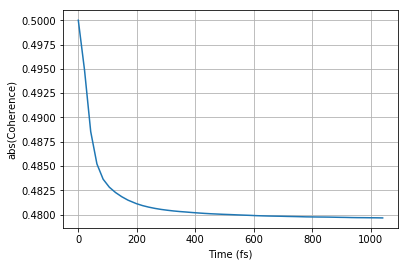

In [10]:
coherences = [mp.trace(mp.dot(state, tmps.matrix_to_mpo(
                                        np.array([[0, 1], [0, 0]]), [[2, 2]])))
              for state in states]
times_in_fs = list(5308 * np.array(times))
plt.plot(times_in_fs, np.abs(coherences))
plt.xlabel("Time (fs)")
plt.ylabel("abs(Coherence)")
plt.grid()
plt.show()

## `tedopa2`
Basically works exactly as `tedopa1`, just for a system comprised of two instead of one site. The only difference is that the local Hamiltonian of the system comprises two sites now, and that every parameter related to the environment of a system site needs to be passed once per system site (i.e. twice in total). This enables the user to choose distinct environments for each of the two system sites.

For a two-site system let's assume two two-level sites where the first site is initially in excited and the second in ground state. The chain is 100 oscillators per site long and the state is again represented as MPS.

In [11]:
system_site1 = np.array([1, 0])
system_site2 = np.array([0, 1])
chain_element = np.array([1] + [0] * 7)
init_state = mp.MPArray.from_kron([chain_element] * 100 + [system_site1] + [
    system_site2] + [chain_element] * 100)
init_state = tmps.normalize(init_state, 'mps')

method = 'mps'

The local Hamiltonian is H<sub>loc</sub> = (e<sub>1</sub> &frasl; 2) (&sigma;<sub>z</sub> &otimes; &#120128;) + (e<sub>2</sub> &frasl; 2) (&#120128; &otimes; &sigma;<sub>z</sub>) + K (&sigma;<sub>+</sub> &otimes; &sigma;<sub>-</sub> + &sigma;<sub>-</sub> &otimes; &sigma;<sub>+</sub>), the coupling matrix A stays the same but the spectral density is different from the one chosen for the model for `tedopa1`.

In [12]:
sp = np.array([[0, 1], [0, 0]])  # sigma+
sm = np.array([[0, 0], [1, 0]])  # sigma-

e1 = 100
e2 = 0
K = 100
g = 4000

h_loc = e1 / 2 * np.kron(sz, np.identity(2)) + e2 / 2 * np.kron(np.identity(
    2), sz) + K * np.kron(sp, sm) + K * np.kron(sm, sp)
a = (np.identity(2) + sz) / 4

lambd = 10
gamma = 53
j = lambda x: 8 * lambd * gamma * x / (x ** 2 + gamma ** 2)
domain = [0, g]

In [13]:
trotter_order = 2
num_slices = 100

final_time = 0.07
ts_full = []
ts_system = np.linspace(0, final_time, 50)

compr = dict(method='svd', relerr=1e-10)
trotter_compr = dict(method='svd', relerr=1e-4, rank=30)

ncap = 20000
v = 1

Now all parameters are known in principle, but as mentioned before all environment related parameters need to be provided twice. Since both sites are chosen to have the exact same individual environment in this example, parameters like `a` and `j` can be passed as `[a]*2` or `[j]*2`.

There is also one additional parameter, `sys_position`. It tells the algorithm where the system is located. It must be the chain length of the left part of the chain. That is 100 in our case.

In [14]:
times, states = td.tedopa2(h_loc=h_loc,
                           a_twosite=[a] * 2,
                           compr=compr,
                           domains=[domain] * 2,
                           js=[j] * 2,
                           method=method,
                           state=init_state,
                           sys_position=100,
                           trotter_compr=trotter_compr,
                           ts_full=list(ts_full),
                           ts_system=list(ts_system),
                           gs=[g] * 2,
                           trotter_order=trotter_order,
                           num_trotter_slices=num_slices,
                           ncap=ncap,
                           v=v)

Calculating the TEDOPA mapping...
Proceeding to tmps...
Time evolution operator for Trotter slice calculated, starting Trotter iterations...
1 Trotter iterations finished...
4 Trotter iterations finished...
9 Trotter iterations finished...
16 Trotter iterations finished...
25 Trotter iterations finished...
36 Trotter iterations finished...
49 Trotter iterations finished...
64 Trotter iterations finished...
81 Trotter iterations finished...
100 Trotter iterations finished...
Done with time evolution


The results are again density matrices of states, represented as MPOs. With these we can, for example, plot the expectation value of the population of the first site over time:

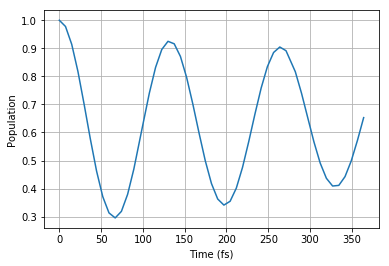

In [15]:
populations = [mp.trace(mp.partialdot(state, tmps.matrix_to_mpo(
                    np.array([[1, 0], [0, 0]]), [[2, 2]]), 0))
               for state in states]
populations = np.real(populations)
times = list(5308 * np.array(times))
plt.plot(times, populations)
plt.xlabel("Time (fs)")
plt.ylabel("Population")
plt.grid()
plt.show()